# Deep Learning for EEG Decoding


*   Data is 4s of 22 channel EEG recordings from 9 total subjects who are imagining 1 of 4 movements

*   Notebook can test the performance of 4 neural networks at decoding the imagined movement: an RNN, CRNN, an CNN designed for use with images, and a CNN designed for EEG data 


###Google Drive and GPU Prep
In Google Colab select Runtime -> Change Runtime Type -> Hardware Accelerator: GPU

In [1]:
#Ensure tensorflow-gpu is installed
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 52kB/s 


In [2]:

%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
/device:GPU:0
Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Data Prep
Data should be stored in a folder on the mounted google drive

In [25]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/content/drive/My Drive/Collab/EEG_Decoding')#add path of folder containing data in Google Drive (change accordingly)
import numpy as np
import tensorflow as tf
import joblib
import os
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import itertools
from sklearn.metrics import confusion_matrix
import importlib

import eeg_models
importlib.reload(eeg_models)
from eeg_models import RNN,Image_CNN,CRNN,EEG_CNN

#plot_confusion_matrix code from https://www.tensorflow.org/tensorboard/image_summaries
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > threshold else "black"
      plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

data = joblib.load('/content/drive/My Drive/Collab/EEG_Decoding/data_mov.sav')

data['X_test']=np.squeeze(data['X_test'])
data['X_train']=np.squeeze(data['X_train'])
data['X_val'] = np.squeeze(data['X_val'])

#Gives subject id for each recording (row)
person_train = np.load("person_train.npy")
person_test = np.load("person_test.npy")
person_val = np.load("person_val.npy")

person_train = np.squeeze(person_train)
person_test = np.squeeze(person_test)
person_val = np.squeeze(person_val)

#samples taken at 250Hz, full data is 4s long
num_bins = 1000 
#uncomment if testing on lower number of bins
#num_bins = np.shape(data['X_train'])[2]
x_train = data['X_train'][:,:,0:num_bins]
y_train = data['y_train']
x_test = data['X_test'][:,:,0:num_bins]
y_test = data['y_test']
x_val = data['X_val'][:,:,0:num_bins]
y_val = data['y_val']

x_train = x_train.transpose(0,2,1)
x_test = x_test.transpose(0,2,1)
x_val = x_val.transpose(0,2,1)


y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
y_train = to_categorical(y_train)


data_adj = {
    'X_train':x_train,
    'y_train':y_train,
    'X_val':x_val,
    'y_val':y_val,
    'X_test':x_test,
    'y_test':y_test,
}
for k in data_adj.keys():
    print('{}: {}'.format(k,data_adj[k].shape))
print('{}: {}'.format("person_train",person_train.shape))
print('{}: {}'.format("person_val",person_val.shape))
print('{}: {}'.format("person_test",person_test.shape))

#To store data if training on single subject
x_train_full = x_train
y_train_full = y_train
x_val_full = x_val
y_val_full = y_val
x_test_full = x_test
y_test_full = y_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X_train: (1903, 1000, 22)
y_train: (1903, 4)
X_val: (212, 1000, 22)
y_val: (212, 4)
X_test: (443, 1000, 22)
y_test: (443, 4)
person_train: (1903,)
person_val: (212,)
person_test: (443,)


### Choose to train on all subjects, or a specific subject

In [60]:
use_subj = 0 #set to 1 if training on only 1 subject
if(use_subj):
  subj = 0#choose which subject to train on
  
  print(f"Using subject {subj}")
  idxs = np.nonzero(person_train==subj)
  x_train,y_train = x_train_full[idxs],y_train_full[idxs]
  idxs = np.nonzero(person_val==subj)
  x_val,y_val = x_val[idxs],y_val[idxs]
  idxs = np.nonzero(person_test==subj)
  idxs_gen = np.nonzero(person_test!=subj)
  x_gen,y_gen = x_test[idxs_gen],y_test[idxs_gen]#store data from other subjects to test generalizability
  x_test,y_test = x_test[idxs],y_test[idxs]

  num_bins = x_train.shape[1]
  print(f"Using {num_bins} bins")
  data_adj = {
      'X_train':x_train,
      'y_train':y_train,
      'X_val':x_val,
      'y_val':y_val,
      'X_test':x_test,
      'y_test':y_test,
      'x_gen': x_gen,
      'y_gen': y_gen,
  }
  for k in data_adj.keys():#view new data
      print('{}: {}'.format(k,data_adj[k].shape))

  num_bins = x_train.shape[1]

else:
  #reset data to all subjects if it was changed
  x_train = x_train_full
  y_train = y_train_full
  x_val = x_val_full
  y_val = y_val_full
  x_test = x_test_full
  y_test = y_test_full
  data_adj = {
      'X_train':x_train,
      'y_train':y_train,
      'X_val':x_val,
      'y_val':y_val,
      'X_test':x_test,
      'y_test':y_test,
  }
  for k in data_adj.keys():#view data
      print('{}: {}'.format(k,data_adj[k].shape))
  print("Using All Subjects")

X_train: (1903, 1000, 22)
y_train: (1903, 4)
X_val: (212, 1000, 22)
y_val: (212, 4)
X_test: (443, 1000, 22)
y_test: (443, 4)
Using All Subjects


###Neural Network Training

1.   Model is imported from eeg_models.py file
2.   Flow Diagram shows shape
3.   Model is trained using a learning rate schedule of 20 epochs with a learning rate of $10^{-3}$ and another 20 epochs with a learning rate of $10^{-4}$




In [61]:
#Leave a single model uncommented to use it
importlib.reload(eeg_models)
from eeg_models import RNN,Image_CNN,EEG_CNN,CRNN

#model= Image_CNN(num_classes=4,input_dim=(num_bins,22),dropout=0.5,filter_size=[3,3],num_filter=[50,100])
#model= RNN(num_classes=4,input_dim=(num_bins,22),dropout=0.5,lstm_units=100)
model= EEG_CNN(num_classes=4,input_dim=(num_bins,22),num_filter=[50,100],dropout=0.5,filter_size=[22,75])
#model= CRNN(num_classes=4,input_dim=(num_bins,22),dropout=0.5,num_filter=100,filter_size=22)
print(model.summary())

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1000, 1, 50)       1150      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 926, 1, 100)       375100    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 72, 1, 100)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 72, 1, 100)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 72, 1, 100)       

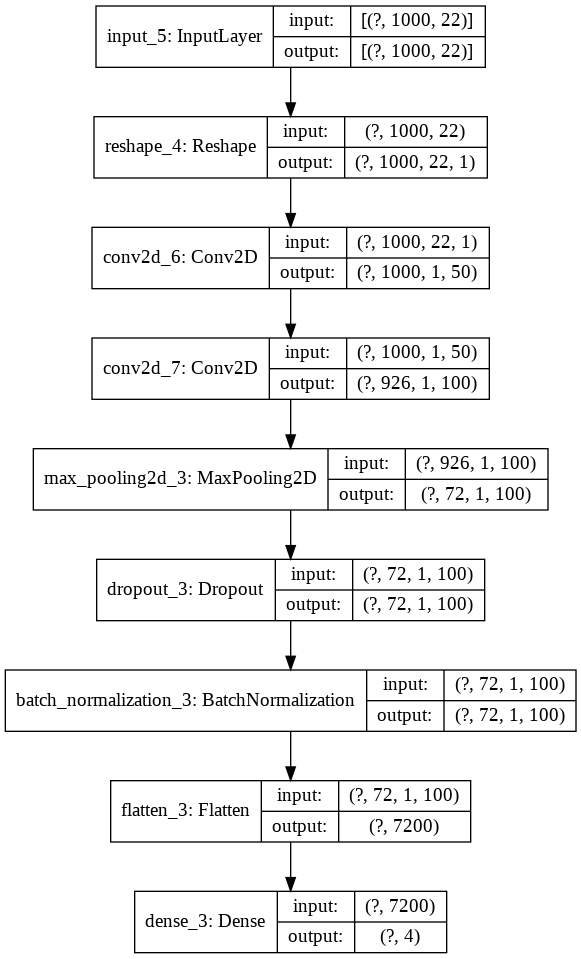

In [62]:
#get flow diagram
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [63]:
#first training run
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics = ['categorical_accuracy'])
history = model.fit(x_train,y_train,epochs=20,batch_size=64,validation_data=(x_val,y_val),verbose=True)


Epoch 1/20
30/30 [==============================] - 1s 34ms/step - loss: 1.9029 - categorical_accuracy: 0.3100 - val_loss: 3.7993 - val_categorical_accuracy: 0.3585
Epoch 2/20
30/30 [==============================] - 1s 27ms/step - loss: 1.5688 - categorical_accuracy: 0.4225 - val_loss: 1.5370 - val_categorical_accuracy: 0.4623
Epoch 3/20
30/30 [==============================] - 1s 27ms/step - loss: 1.3132 - categorical_accuracy: 0.5292 - val_loss: 1.2940 - val_categorical_accuracy: 0.5755
Epoch 4/20
30/30 [==============================] - 1s 27ms/step - loss: 1.1204 - categorical_accuracy: 0.5933 - val_loss: 1.2069 - val_categorical_accuracy: 0.5755
Epoch 5/20
30/30 [==============================] - 1s 27ms/step - loss: 0.9560 - categorical_accuracy: 0.6700 - val_loss: 1.0902 - val_categorical_accuracy: 0.6274
Epoch 6/20
30/30 [==============================] - 1s 27ms/step - loss: 0.8504 - categorical_accuracy: 0.7147 - val_loss: 1.0150 - val_categorical_accuracy: 0.6462
Epoch 7/20

In [64]:
#second training run
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics = ['categorical_accuracy'])
history2 = model.fit(x_train,y_train,epochs=20,batch_size=64,validation_data=(x_val,y_val),verbose=True)


Epoch 1/20
30/30 [==============================] - 1s 31ms/step - loss: 0.2208 - categorical_accuracy: 0.9869 - val_loss: 1.0442 - val_categorical_accuracy: 0.7170
Epoch 2/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1961 - categorical_accuracy: 0.9926 - val_loss: 1.0539 - val_categorical_accuracy: 0.6981
Epoch 3/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1846 - categorical_accuracy: 0.9984 - val_loss: 1.0222 - val_categorical_accuracy: 0.7075
Epoch 4/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1783 - categorical_accuracy: 0.9968 - val_loss: 1.0449 - val_categorical_accuracy: 0.7028
Epoch 5/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1709 - categorical_accuracy: 0.9974 - val_loss: 1.0589 - val_categorical_accuracy: 0.7028
Epoch 6/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1670 - categorical_accuracy: 0.9979 - val_loss: 1.0414 - val_categorical_accuracy: 0.7028
Epoch 7/20

## Evaluate Model

In [65]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} \nTest accuracy: {score[1]}')
test_acc = int(score[1]*100)

if(use_subj): #if trained on only one subject
  score_gen = model.evaluate(x_gen, y_gen, verbose=0)#evaluate on other subjects
  print(f'Generalization Test loss: {score_gen[0]} \nGeneralization Test accuracy: {score_gen[1]}')
  gen_acc = int(score_gen[1]*100)

Test loss: 1.0360931158065796 
Test accuracy: 0.697516918182373


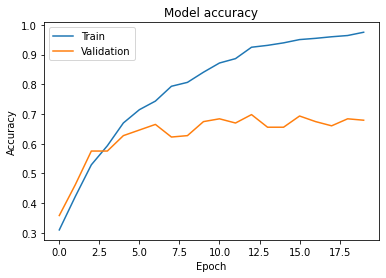

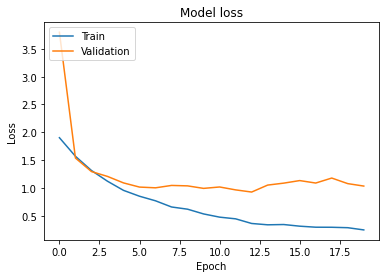

In [66]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


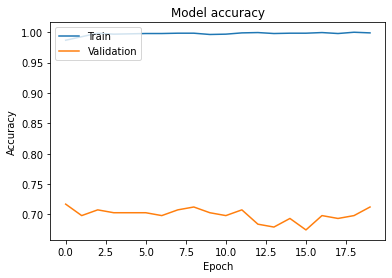

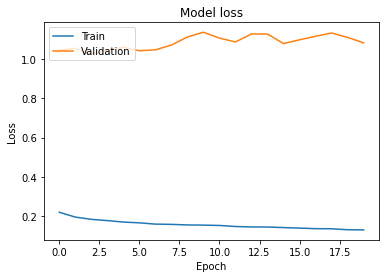

In [67]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


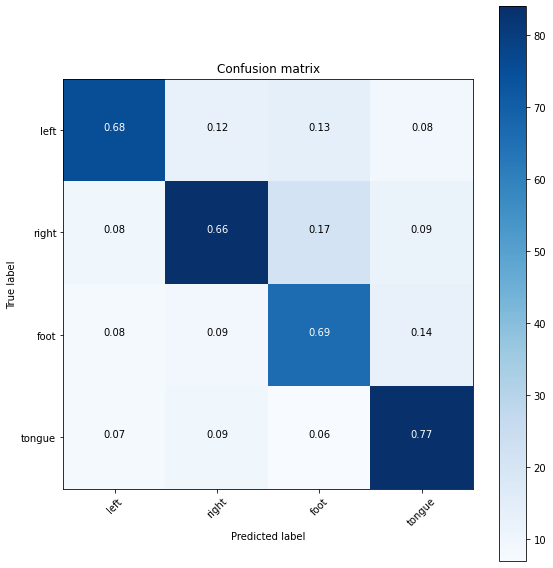

In [68]:
y_pred = model.predict(x_test)
y_pred_num = np.argmax(y_pred,axis=1)
y_test_num = np.argmax(y_test,axis=1)
test_acc_num = np.mean(y_pred_num==y_test_num)
cm = confusion_matrix(y_test_num,y_pred_num)
class_labels = ['left','right','foot','tongue']
x =plot_confusion_matrix(cm,class_labels)


In [69]:
#Save model, change name accordingly
path = f'/content/drive/My Drive/Collab/EEG_Decoding/models/model_{test_acc}acc_{num_bins}bins'
tf.keras.models.save_model(model,path)


INFO:tensorflow:Assets written to: /content/drive/My Drive/Collab/EEG_Decoding/models/model_69acc_1000bins/assets
